In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from transformers import BertTokenizer
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import seaborn as sns
import statistics
import math
import os
import regex as re
import pandas as pd
from tqdm import tqdm, trange



from tensorflow.keras.optimizers import SGD
df = pd.read_csv("/Users/revglue/study/main_work/my_working/my_data_set/my_data_set.csv")
df.head(5)

,Annotator,Paper,Cited-by,Follow-up,Citing Sentence,Tagged Sentence
0,A,A00-1043,C00-2140,0,Since we only use shallow methods for textual ...,Since we only use shallow methods for textual ...
1,A,A00-1043,P02-1057,0,Sentence simplification systems (Chandrasekar ...,Sentence simplification systems (GTREF) are ca...
2,A,A97-1011,W09-1118,1,Each token is represented using a fairly stand...,Each token is represented using a fairly stand...
3,A,A97-1011,A00-2017,1,The training and the test data were processed ...,The training and the test data were processed ...
4,A,A97-1011,C00-2099,0,The only other high- delity computational rend...,The only other high-_x005f delity computationa...


In [2]:
df['Citation Type']=df['Follow-up'].apply(lambda x: 'Related work' if x==0 else ('Comparison' if x==1 else ('Using the work' if x==2 else 'Extending the work')))

In [3]:
import math

def softmax(z):
    z_exp = [math.exp(i) for i in z]
    sum_z_exp = sum(z_exp)
    return [i / sum_z_exp for i in z_exp]

In [4]:
df['Coarse Label']=df['Follow-up'].apply(lambda x: 'Incidental' if x==0 or x==1 else 'Important')
df['normalized']=softmax(df['Follow-up'])

df.head(15)

,Annotator,Paper,Cited-by,Follow-up,Citing Sentence,Tagged Sentence,Citation Type,Coarse Label,normalized
0,A,A00-1043,C00-2140,0,Since we only use shallow methods for textual ...,Since we only use shallow methods for textual ...,Related work,Incidental,0.000508
1,A,A00-1043,P02-1057,0,Sentence simplification systems (Chandrasekar ...,Sentence simplification systems (GTREF) are ca...,Related work,Incidental,0.000508
2,A,A97-1011,W09-1118,1,Each token is represented using a fairly stand...,Each token is represented using a fairly stand...,Comparison,Incidental,0.001380
3,A,A97-1011,A00-2017,1,The training and the test data were processed ...,The training and the test data were processed ...,Comparison,Incidental,0.001380
4,A,A97-1011,C00-2099,0,The only other high- delity computational rend...,The only other high-_x005f delity computationa...,Related work,Incidental,0.000508
5,A,A97-1011,W04-1505,0,The Statistical Dependency Model Most successf...,The Statistical Dependency Model Most successf...,Related work,Incidental,0.000508
6,A,A97-1011,P99-1033,0,J~irvinen and Tapananinen have demonstrated an...,J~irvinen and Tapananinen have demonstrated an...,Related work,Incidental,0.000508
7,A,A97-1011,W06-0202,3,Generating Dependency Patterns Three dependenc...,Generating Dependency Patterns Three dependenc...,Extending the work,Important,0.010196
8,A,A97-1011,P01-1006,3,Pre-processing tools Parser The current versio...,Pre-processing tools Parser The current versio...,Extending the work,Important,0.010196
9,A,A97-1011,E12-1072,0,The corpus was parsed by Connexor’s Machinese ...,The corpus was parsed by Connexor’s Machinese ...,Related work,Incidental,0.000508


In [5]:
df['Follow-up'].value_counts()

1    283
0    252
2     55
3     27
Name: Follow-up, dtype: int64

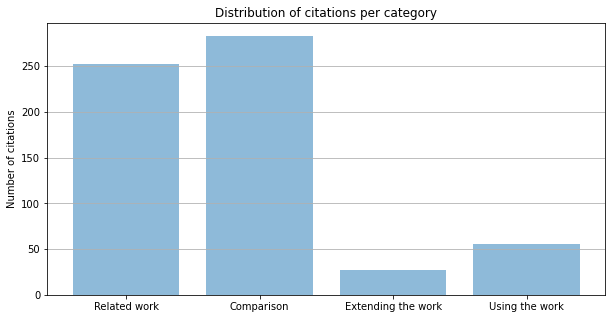

Counter({'Comparison': 283, 'Related work': 252, 'Using the work': 55, 'Extending the work': 27})


In [6]:
from collections import Counter

categories = df[['Citation Type']].values.reshape(-1)

counter_categories = Counter(categories)
category_names = counter_categories.keys()
category_values = counter_categories.values()

y_pos = np.arange(len(category_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, category_values, align='center', alpha=0.5)
plt.xticks(y_pos, category_names)
plt.ylabel('Number of citations')
plt.title('Distribution of citations per category')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [7]:
def calculate_stats(df, split_char=' '):
    categories = df['Citation Type'].unique()
    
    all_lengths = []
    per_category = {
        'lengths': {c:[] for c in categories},
        'mean': {c:0 for c in categories},
        'stdev': {c:0 for c in categories}
    }

    for index, row in df.iterrows():
        text = row['Tagged Sentence']
        text = re.sub(r"\s+", ' ', text) # Normalize
        text = text.split(split_char)
        l = len(text)
        
        category = row['Citation Type']
        
        all_lengths.append(l)
        per_category['lengths'][category].append(l)
    
    for c in categories:
        per_category['mean'][c] = statistics.mean(per_category['lengths'][c])
        per_category['stdev'][c] = statistics.stdev(per_category['lengths'][c])
    
    global_stats = {
        'mean': statistics.mean(all_lengths),
        'stdev': statistics.stdev(all_lengths),
        'lengths': all_lengths
    }
    
    return {
        'global': global_stats,
        'per_category': pd.DataFrame(per_category)
    }

In [8]:
def display_lengths_histograms(df_stats, n_cols=3):
    categories = df['Citation Type'].unique()
    n_rows = math.ceil(len(categories) / n_cols)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle('Distribution of lengths')
    
    # Subplot of all lengths
    plt.subplot(n_rows, n_cols, 1)
    plt.title('All categories')
    lengths = df_stats['global']['lengths']
    plt.hist(lengths, color='r')

    # Subplot of each category
    index_subplot = 2
    for c in categories:
        plt.subplot(n_rows, n_cols, index_subplot)
        plt.title('Category: %s' % c)
        
        lengths = df_stats['per_category']['lengths'][c]
        plt.hist(lengths, color='b')

        index_subplot += 1

    plt.show()

In [9]:
df_stats = calculate_stats(df)
df_stats['per_category']

,lengths,mean,stdev
Related work,"[29, 16, 26, 16, 13, 30, 36, 21, 23, 45, 15, 1...",26.674603,12.731571
Comparison,"[69, 13, 8, 14, 32, 18, 43, 51, 37, 47, 27, 17...",28.028269,17.926542
Extending the work,"[26, 24, 26, 162, 269, 140, 91, 127, 204, 46, ...",113.814815,100.246633
Using the work,"[68, 12, 133, 56, 109, 175, 14, 132, 23, 142, ...",59.218182,54.376496


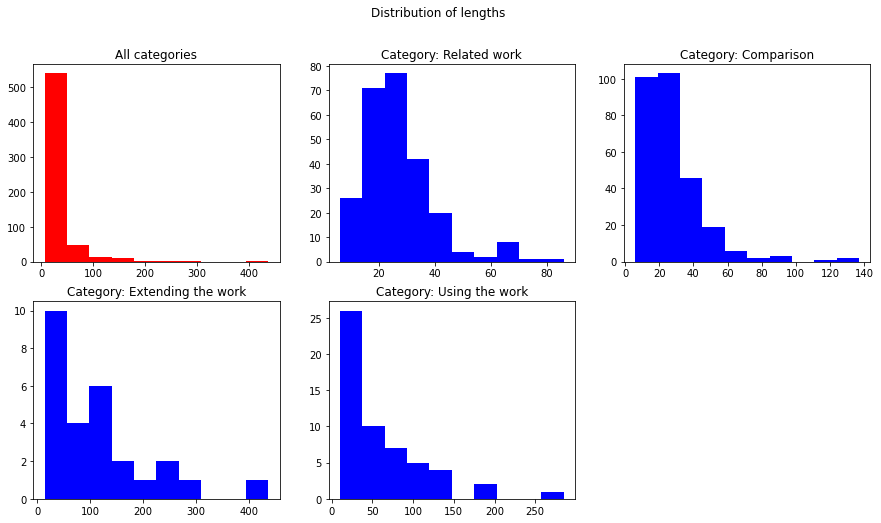

In [10]:
display_lengths_histograms(df_stats)

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [12]:
token = tokenizer.encode_plus(
    df['Tagged Sentence'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)

2022-08-19 10:17:56.781324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
import numpy as np

X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

print(X_input_ids)
print("\n------\n")
print(X_attn_masks)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

------

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [14]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['Tagged Sentence'])):
        print(text)
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [15]:
from tqdm.auto import tqdm

X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

Since we only use shallow methods for textual analysis that do not generate a dependency structure, we cannot use complex methods for text reduction as described, e.g., in TREF.
Sentence simplification systems (GTREF) are capable of compressing long sentences by deleting unimportant words and phrases.
Each token is represented using a fairly standard menagerie of features, including such stemming from the surface appearance of the token (e.g., Contains dollar? Length in characters), calculated based on linguistic pre-processing made with the English Functional Dependency Grammar TREF (e.g., Case, Part-of-speech), fetched from precompiled lists of information (e.g., Is first name?), and features based on predictions concerning the context of the token (e.g, Class of previous token).
The training and the test data were processed by the FDG parser TREF.
The only other high-_x005fdelity computational rendering of Tesniere's dependency syntax that we are aware of is that of TREF, which is 

For preprocessing, all the sentences in the Bioscope corpus are tokenized and then parsed using the Berkeley parser2 REF trained on the GENIA TreeBank (GTB) 1.0 TREF3 , which is a bracketed corpus in (almost) PTB style.
The BioNLP’09 shared task involved documents contained also in the GENIA treebank TREF, creating an opportunity for direct study of intrinsic and task-oriented evaluation results. GENIA treebank processing For comparison and evaluation, the texts in the GENIA treebank TREF are converted to the various formats as follows.
We used the Stanford parser REF, and also a variant of the Stanford parser (i.e., Stanford-Genia), which was trained on the GENIA treebank TREF for biomedical text;
Our biomedical data comes from the GENIA treebank8 TREF, a corpus of abstracts from the Medline database.9
Because our target is biomedical texts, we re-trained a parser REF with the GENIA treebank TREF, and also applied a bidirectional part-ofspeech tagger REF trained with the GENIA treeban

Online learning algorithms have been shown to be robust even with approximate rather than exact inference in problems such as word alignment REF, sequence analysis REF and phrase-structure parsing TREF.
In particular, most of the work on parsing with kernel methods has focussed on kernels over parse trees (GTREF). For comparison to previous results, table 2 lists the results on the testing set for our best model (TOP-Efficient-Freq≥20) and several other statistical parsers (GTREF). When compared to other kernel methods, our approach performs better than those based on the Tree kernel (GTREF), and is only 0.2% worse than the best results achieved by a kernel method for parsing REF.
Perceptron-based training To tune the parameters w of the model, we use the averaged perceptron algorithm TREF because of its efficiency and past success on various NLP tasks (GTREF).
Following recent work applying global discriminative models to large-scale structured prediction problems (GTREF), we build ou

Note that, while we restrict our discussion to analysis of Japanese sentences in this paper, what we present below should also be straightforwardly applicable to more wideranged tasks such as English dependency analysis just like the problem setting considered by TREF. Estimation of DPs Some of the state-of-the-art probabilistic language models such as the bottomup models P (Rjs) proposed by TREF and REF directly estimate DPs for a given input, whereas other models such as PCFGbased topdown generation models P (R; s) do not (GTREF). CHAGAKE REF: an extension of the bottom-up model proposed by Collins TREF.
As the development of corpus linguistics, many statistics-based parsers were proposed, such as REF’s statistical decision tree parser, TREF’s bigram dependency model parser, REF’s maximum entropy model parser.
(GTREF) use the lexical informationand REF use the contextual information for structural disambiguation.
The features are extracted using a statistical parser TREF, and consist

Linear CRF model has been successfully applied in NLP and text mining tasks (GTREF).
Information extraction Finally, there exist large bodies of work on information extraction using models based on Markov and semi-Markov CRFs REF, and in particular for the task of named entity recognition TREF.
Current studies of NER mainly focus on formal text such as news articles (GTREF).
A wide variety of machine learning methods have been applied to this problem, including Hidden Markov Models REF, Maximum Entropy methods REF, Decision Trees REF, Conditional Random Fields TREF, Class-based Language Model REF, Agent-based Approach REF and Support Vector Machines.
Such models are well suited to sequence analysis, and CRFs in particular have been shown to be useful in partof-speech tagging REF, shallow parsing REF, and named entity recognition for newswire data TREF.
Note that our formulation of CRFs is different from the widely-used formulations (e.g., (GTREF).
While global statistical approaches, s

The empirical investigations described here and below use the data set of TREF. The task is to classify names in text as person, location, or organization.
Similar approaches are used among others in REF for learning semantic lexicons, in TREF for namedentity recognition, and in REF for hierarchical text categorization.
TREF and REF apply bootstrapping to the related task of named-entity recognition.
Co-training has also been used for named entity recognition (NER) TREF, coreference resolution REF, text categorization REF and improving gene name data REF.
The first-order features φ1(x, h, m) are the exact same implementation as in previous CoNLL system TREF.
Graph-based (GTREF) and transition-based (REF) parsing algorithms offer two different approaches to data-driven dependency parsing.
For testing, all training data are used for training, with the number of training iterations set to be the number which gave the highest accuracy during the development experiments. This method was u

Some stem from work on graphical models, including loopy belief propagation REF, Gibbs sampling TREF, sequential Monte Carlo methods such as particle filtering REF, and variational inference TREF. Also relevant are stacked learning REF, interpretable as approximation of non-local feature values REF, and M-estimation REF, which allows training without inference.
In all the experiments, our source side language is English, and the Stanford Named Entity Recognizer TREF was used to extract NEs from the source side article.
The features include the NP head noun and its premodifiers. We also use the Stanford NER tagger TREF to identify Named Entities within the NP.
For semantic role labeling we use SWIRL9 , for chunk parsing CASS REF and for constituency parsing Stanford Parser REF. Named-entity information is provided by Stanford Tagger TREF.
Named Entity The replaced token should not be part of a named entity. For this purpose, we applied the Stanford NER TREF.
In the first approach,

We validate the hypothesis that using linguistic features, e.g., part-of-speech tags REF, named-entity tags TREF, and dependency trees REF, helps improve the quality of our approach, called Joint.
Similarly, distributional features support generalization in Named Entity Recognition TREF.
We used 500,000 Wikipedia articles (2,000,000 sentences) for generating training data for the NED component. We used Open NLP POS tagger, Standford NER TREF and MaltParser REF to label/tag sentences.
State-of-the-art tools for named entity recognition such as the Stanford NER Tagger TREF compute semantic tags only for a small set of coarse-grained types: Person, Location, and Organization (plus tags for non-entity phrases of type time, money, percent, and date).
The first is named entity (NE) tags (PERSON, ORGANIZATION and LOCATION) returned by the Stanford NE recognition tool TREF.
Corry has only participated in the “open” setting, as it has already a number of preprocessing modules integrated into

Entities were found using the Stanford named entity tagger TREF, and were matched to their name in Freebase.
NER is a fairly researched field (GTREF) and is also used in several commercial applications such as Zemanta, OpenCalais and AlchemyAPI , which are able to automatically insert links for a NE pointing to a knowledge base such as Wikipedia or IMDB.
A common approach is to utilize a Named Entity Recognition (NER) system like Stanford NER TREF, which recognizes the names of things (e.g., person and product names) from texts.
To assign types to arguments, we apply Stanford Named Entity Recognizer TREF, and also look up the argument in WordNet 2.1 and record the first three senses if they map to our target semantic types.
We identified these mentions of persons using Stanford NER TREF and treated each person mention as a single token.
Stanford NER (or in short Stanford) associated to the following model provided by the tool and which was trained on different news corpora (CoNLL,

It includes: cleaning up and normalization of the input using regular expressions, sentence segmentation, tokenization and lemmatization using GATE REF, syntactical parsing and dependency parsing (collapsed) using the Stanford Parser REF, and Named Entity Recognition using Stanford NER TREF.
For example, the average F1 of the Stanford NER TREF drops from 90.8% REF to 45.8% on tweets, while Liu et al. (2010) report that the F1 score of a state-ofthe-art SRL system REF falls to 42.5% on tweets as apposed to 75.5% on news.
BIUTEE provides state-of-the-art pre-processing utilities: Easy-First parser REF, Stanford named-entity-recognizer TREF and ArkRef coreference resolver REF, as well as utilities for sentencesplitting and numerical-normalizations.
The Stanford CRF-based NER tagger was used as the monolingual component in our models TREF.
We utilize the Stanford tools (GTREF).
Most well-known is the Stanford named entity recognition (NER) tagger TREF which assigns coarse-grained typ

In [16]:
X_input_ids

array([[  101.,  1967.,  1195., ...,     0.,     0.,     0.],
       [  101., 14895.,  5208., ...,     0.,     0.,     0.],
       [  101.,  2994., 22559., ...,     0.,     0.,     0.],
       ...,
       [  101.,  1284.,  1231., ...,     0.,     0.,     0.],
       [  101., 22841.,  5537., ...,     0.,     0.,     0.],
       [  101.,  1706., 16143., ...,     0.,     0.,     0.]])

In [17]:
X_attn_masks

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [18]:
labels = np.zeros((len(df), 4))
labels.shape

(617, 4)

In [19]:
labels[np.arange(len(df)), df['Follow-up'].values] = 1 # one-hot encoded target tensor

In [20]:
labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))>

In [22]:
def CitationDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [23]:
dataset = dataset.map(CitationDatasetMapFunction) # converting to required format for tensorflow dataset

In [24]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(4,), dtype=tf.float64, name=None))>

In [25]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [26]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 4), dtype=tf.float64, name=None))>

In [27]:
p = 0.8
train_size = int((len(df)/16)*p) # for each 4 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [28]:
print(train_size)
print(len(df))

30
617


In [29]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [30]:
len(train_dataset)

30

In [31]:
from transformers import TFBertModel

In [32]:
model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [33]:
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(4, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

citation_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
citation_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [34]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [35]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [36]:
citation_model.compile(optimizer=optim, loss=loss_func, metrics=[tf.keras.metrics.CategoricalAccuracy('accuracy'),
                              tf.keras.metrics.Precision(),
                              tf.keras.metrics.Recall(),
                              tfa.metrics.F1Score(num_classes=4,
                                                  average='micro',
                                                  threshold=0.5)])

In [37]:
hist = citation_model.fit(
    train_dataset,
    validation_data=val_dataset,
    batch_size=8,
    verbose=1,                    
    epochs=10
)

Epoch 1/10
30/30 [==============================] - 1907s 63s/step - loss: 1.1250 - accuracy: 0.5500 - precision: 0.7685 - recall: 0.1729 - f1_score: 0.2823 - val_loss: 0.9563 - val_accuracy: 0.6094 - val_precision: 0.7471 - val_recall: 0.5078 - val_f1_score: 0.6047
Epoch 2/10
30/30 [==============================] - 2070s 69s/step - loss: 0.8553 - accuracy: 0.6812 - precision: 0.7197 - recall: 0.6313 - f1_score: 0.6726 - val_loss: 0.5892 - val_accuracy: 0.8047 - val_precision: 0.8462 - val_recall: 0.7734 - val_f1_score: 0.8082
Epoch 3/10
30/30 [==============================] - 2289s 77s/step - loss: 0.7446 - accuracy: 0.7375 - precision: 0.7878 - recall: 0.6729 - f1_score: 0.7258 - val_loss: 0.7880 - val_accuracy: 0.7109 - val_precision: 0.7607 - val_recall: 0.6953 - val_f1_score: 0.7265
Epoch 4/10
30/30 [==============================] - 1934s 65s/step - loss: 0.6453 - accuracy: 0.7708 - precision: 0.8392 - recall: 0.7396 - f1_score: 0.7863 - val_loss: 0.5017 - val_accuracy: 0.8125 

In [38]:
citation_model.save('bert_model_tagged_sentences')

INFO:tensorflow:Assets written to: bert_model_tagged_sentences/assets


INFO:tensorflow:Assets written to: bert_model_tagged_sentences/assets


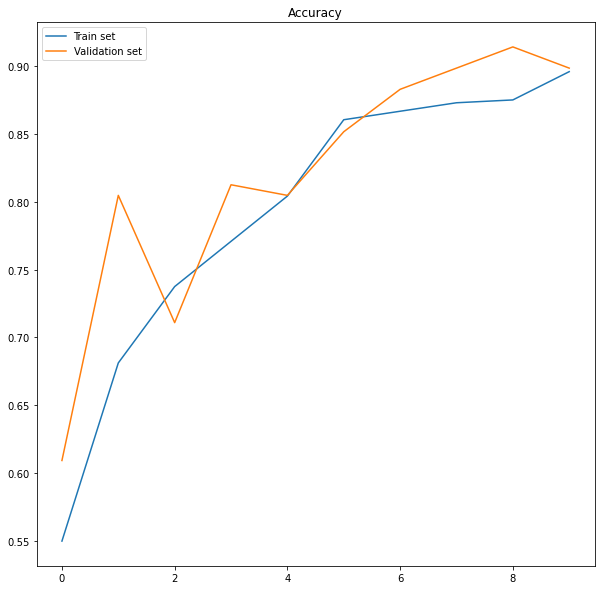

In [39]:
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(hist.history['accuracy']))
plt.plot(xaxis, hist.history['accuracy'], label='Train set')
plt.plot(xaxis, hist.history['val_accuracy'], label='Validation set')
plt.legend()

In [40]:
scores = citation_model.evaluate(val_dataset, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 85.94%
